In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt

#make plots inline using jupyter magic
%matplotlib inline

import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import datasets, linear_model, metrics


import matplotlib as mpl
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
#Balanced RF Classifier
from imblearn.ensemble import BalancedRandomForestClassifier as BRF

from IPython.display import Markdown as md  #enable markdown within code cell
from IPython.display import display, Math, Latex

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix
import time
import random
import scipy

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, precision_recall_curve, make_scorer,f1_score
from sklearn.metrics import precision_recall_curve as PRC
from sklearn.decomposition import PCA

## Homemade code imports
import metrics

data_dir = '/run/media/mnewlin/_userdata/uhnds/'
original_netflow_data_dir = data_dir + 'network/extracted/'
original_netflow_file = 'netflow_day-02'
fake_dir = '/run/media/mnewlin/_userdata/uhnds/network/converted/fake/'
real_dir = '/run/media/mnewlin/_userdata/uhnds/network/converted/real/'
real_file = 'netflow_day-02'

In [2]:
"""
    Function to read in a single real sample from a given directory based
    on the desired length of the sample.
"""
def load_real_sample(sample_num, sample_length=100):

    data_dir = 'samples_{}/'.format(sample_length)
    if sample_length < 10000:
        if sample_num >= 10000:
            return -1
    elif sample_length < 100000:
        if sample_num >= 2000:
            return -1
    else:
        if sample_num >= 2000:
            return -1
        
    load_file = real_file + '_sample_{}.txt'.format(sample_num)
    filename = real_dir + data_dir + load_file
    df = pd.read_csv(filename, names=['Duration', 'SrcDevice', 
            'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 
            'SrcBytes', 'DstBytes'], sep=' ', dtype=np.float64)
    return df

In [3]:
"""
    Function to read in a single fake sample from a given directory based
    on the desired length of the sample.
"""
def load_fake_sample(sample_num, sample_length=100):
    data_dir = 'samples_{}/'.format(sample_length)
    if sample_length < 10000:
        if sample_num >= 10000:
            return -1
    elif sample_length < 100000:
        if sample_num >= 2000:
            return -1
    else:
        if sample_num >= 2000:
            return -1

    load_file = real_file + '_random_sample_{}.txt'.format(sample_num)
    filename = fake_dir + data_dir + load_file
    df = pd.read_csv(filename, names=['Duration', 'SrcDevice', 
            'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 
            'SrcBytes', 'DstBytes'], sep=' ', dtype=np.float64)
    return df

In [4]:
def load_n_samples(real=True, sample_length=100, num_samples=100, random_state=69):
    data = pd.DataFrame()
    sample_range = 0
    if sample_length <= 1000:
        sample_range = 10000
    elif sample_length <= 10000:
        sample_range = 2000
    elif sample_length <= 100000:
        sample_range = 1160
        
    random.seed(a=random_state)
    sample_list = random.sample(range(sample_range), num_samples)
    if real:
        for num in sample_list:
            data = data.append(load_real_sample(sample_length=sample_length, sample_num=num))
    else:
        for num in sample_list:
            data = data.append(load_fake_sample(sample_length=sample_length, sample_num=num))
    return data

In [5]:
def create_sample_mix(ratio, sample_length=100, num_samples=100, random_state=69):
    if ratio == 0:
        return load_n_samples(real=True, sample_length=sample_length, num_samples=num_samples, random_state=random_state)
    elif ratio == 1:
        return load_n_samples(real=False, sample_length=sample_length, num_samples=num_samples, random_state=random_state)
    real = load_n_samples(real=True, sample_length=sample_length, num_samples=num_samples, random_state=random_state)
    fake = load_n_samples(real=False, sample_length=sample_length, num_samples=num_samples, random_state=random_state)
    real_samples = real.sample(frac=1-ratio, random_state=random_state)
    fake_samples = real.sample(frac=ratio, random_state=random_state)
    samples = real_samples.append(fake_samples)
    return samples

In [6]:
def alt_create_sample_mix(ratio, sample_length=100, num_samples=100, random_state=69):
    #print(int(np.around((1-ratio)*num_samples)))
    #print(int(np.around((ratio)*num_samples)))
    real = load_n_samples(real=True, sample_length=sample_length, num_samples=num_samples, random_state=random_state)
    fake = load_n_samples(real=False, sample_length=sample_length, num_samples=num_samples, random_state=random_state)
    bound_val_real = np.around(((1-ratio)*num_samples*sample_length), decimals=2)
    bound_val_fake = np.around((ratio)*num_samples*sample_length, decimals=2)
    bound_val_real = int(bound_val_real)
    bound_val_fake = int(bound_val_fake)
    #print(bound_val_real)
    #print(bound_val_fake)
    real_samples = real.iloc[:bound_val_real]
    fake_samples = real.iloc[:bound_val_fake]
    samples = real_samples.append(fake_samples)
    return samples

In [7]:
"""
real= np.array(load_n_samples(real=True, sample_length=100,num_samples=10, random_state=42)).astype(np.float64)
mix = np.array(alt_create_sample_mix(ratio=0.1, sample_length=100, num_samples=10, random_state=42)).astype(np.float64)

diff = np.abs(mix-real)
diff = np.reshape(diff, (10, 100, 10))
print(diff[0,0:5])
print(diff[1,0:5])
print(diff[9,0:5])
"""

'\nreal= np.array(load_n_samples(real=True, sample_length=100,num_samples=10, random_state=42)).astype(np.float64)\nmix = np.array(alt_create_sample_mix(ratio=0.1, sample_length=100, num_samples=10, random_state=42)).astype(np.float64)\n\ndiff = np.abs(mix-real)\ndiff = np.reshape(diff, (10, 100, 10))\nprint(diff[0,0:5])\nprint(diff[1,0:5])\nprint(diff[9,0:5])\n'

In [8]:
real_samples = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=333)

### Test alternate approach

In [23]:
real_samples = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=42)
fake_samples = load_n_samples(real=False, sample_length=100,num_samples=100, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=69)
fake_samples_2 = load_n_samples(real=False, sample_length=100,num_samples=100, random_state=69)

Sr1 = np.array(real_samples).astype(np.float64)
Sr2 = np.array(fake_samples).astype(np.float64)
S_2 = np.array(real_samples_2).astype(np.float64)
G_2 = np.array(fake_samples_2).astype(np.float64)

num_cols = Sr1.shape[1]
sample_length = 100
num_samples = 100
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))
S_2 = np.reshape(S_2, (num_samples, sample_length, num_cols))
G_2 = np.reshape(G_2, (num_samples, sample_length, num_cols))


print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_man = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1., r=1.)
print("lp, p=1, r=1: ", d0_man)
d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
#d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
#print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1, S_2, G1=Sr2, G2=G_2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)


True
True
lp, p=1, r=1:  10436588163.147001
lp, p=0.75, r=0.75:  45399158699.867744
lp, p=0.5, r=0.5:  909853044326.1891
euclidean:  1274857241.2478037
cosine:  0.32407160763482923
Mahalanobis:  2.407253777125791
chi:  2.2916987134746664e+45
wasserstein:  103809531.94399
Entropy:  0.715606318421947
Perplexity:  3.645992373865768
MMD:  0.4679077170870044


In [24]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
man_scores = np.array([])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
#fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 100, random_state=42)).astype(np.float64)
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 100, random_state=69)).astype(np.float64)
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    d_man = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1., r=1.)
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    #d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    #d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=S_2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd')
    lp_scores = np.append(lp_scores, d_lp)
    man_scores = np.append(man_scores, d_man)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    #chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    #fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [25]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores
normalized_mah = mah_scores/d0_mah
#normalized_chi = chi_scores/d0_chi
normalized_wass = wass_scores/d0_wass
#normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd
normalized_man = man_scores/d0_man


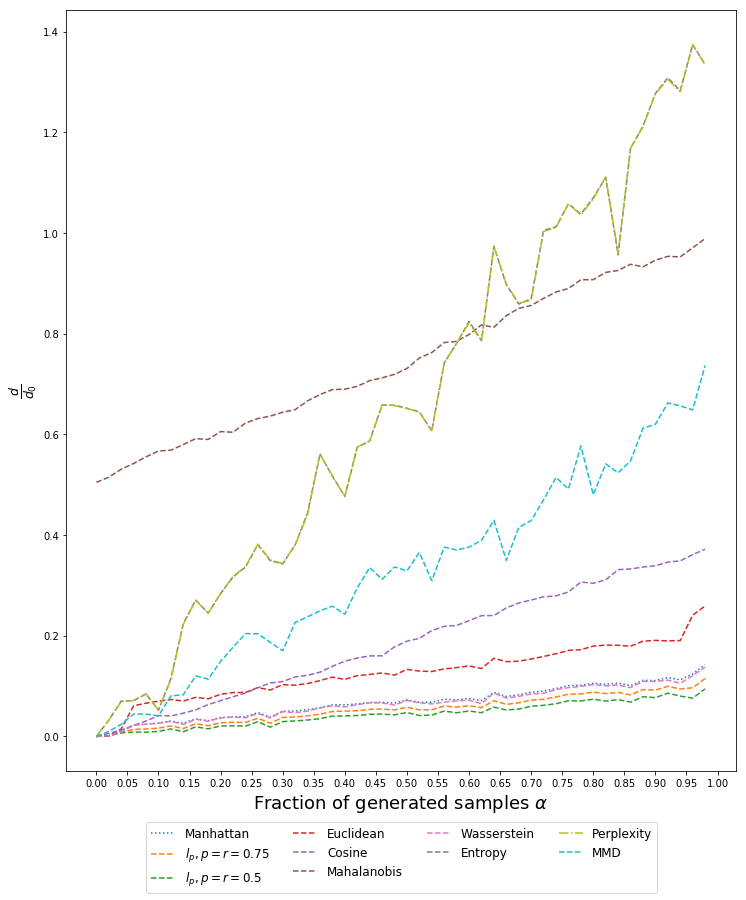

In [31]:

fig = plt.figure(figsize=(12,14))
plt.plot(alphagrid, normalized_man, ':', label='Manhattan')
plt.plot(alphagrid, normalized_lp, '--', label=r'$l_p, p=r=0.75$')
plt.plot(alphagrid, normalized_lp_2, '--', label=r'$l_p, p=r=0.5$')
plt.plot(alphagrid, normalized_euc, '--', label='Euclidean')
plt.plot(alphagrid, normalized_cosine, '--', label='Cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, normalized_mah, '--', label='Mahalanobis')
plt.plot(alphagrid, normalized_wass, '--', label='Wasserstein')
#plt.plot(alphagrid, normalized_fid, '--', label='FID')
plt.plot(alphagrid, normalized_ent, '--', label='Entropy')
plt.plot(alphagrid, normalized_perp, '-.', label='Perplexity')
plt.plot(alphagrid, normalized_mmd, '--', label='MMD')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.ylabel(r'$\frac{d}{d_0}$', fontsize=18)
plt.xlabel(r'Fraction of generated samples $\alpha$', fontsize=18)

plt.legend(fontsize=12, ncol=4, loc=(0.12,-0.16))
plt.savefig('figures/discriminative/eps/untransformed_100_100.eps')
plt.savefig('figures/discriminative/png/untransformed_100_100.png')
plt.show()

## Alt Approach: 100 length 1000 samples

In [9]:
real_samples = load_n_samples(real=True, sample_length=100,num_samples=1000, random_state=42)
fake_samples = load_n_samples(real=False, sample_length=100,num_samples=1000, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=100,num_samples=1000, random_state=69)
fake_samples_2 = load_n_samples(real=False, sample_length=100,num_samples=1000, random_state=69)

Sr1 = np.array(real_samples).astype(np.float64)
Sr2 = np.array(fake_samples).astype(np.float64)
S_2 = np.array(real_samples_2).astype(np.float64)
G_2 = np.array(fake_samples_2).astype(np.float64)

num_cols = Sr1.shape[1]
sample_length = 100
num_samples = 1000
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))
S_2 = np.reshape(S_2, (num_samples, sample_length, num_cols))
G_2 = np.reshape(G_2, (num_samples, sample_length, num_cols))


print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_man = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1., r=1.)
print("lp, p=1, r=1: ", d0_man)
d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
#d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
#print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1, S_2, G1=Sr2, G2=G_2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)


True
True
lp, p=1, r=1:  9835028326.819302
lp, p=0.75, r=0.75:  41788386869.81144
lp, p=0.5, r=0.5:  822130563129.644
euclidean:  1309623353.7155883


/home/mnewlin/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


cosine:  0.35248333526717524


/home/mnewlin/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/mnewlin/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/home/mnewlin/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


Mahalanobis:  2.407930930384997
chi:  4.8670350928461776e+101
wasserstein:  0.010859631930665184


/home/mnewlin/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


Entropy:  0.631208690281584
Perplexity:  3.20736827373524
MMD:  0.4325197415222481


In [10]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
man_scores = np.array([])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
#fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 1000, random_state=42)).astype(np.float64)
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 1000, random_state=69)).astype(np.float64)
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    d_man = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1., r=1.)
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    #d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    #d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=S_2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd')
    lp_scores = np.append(lp_scores, d_lp)
    man_scores = np.append(man_scores, d_man)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    #chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    #fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [11]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores
normalized_mah = mah_scores/d0_mah
#normalized_chi = chi_scores/d0_chi
normalized_wass = wass_scores/d0_wass
#normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd
normalized_man = man_scores/d0_man


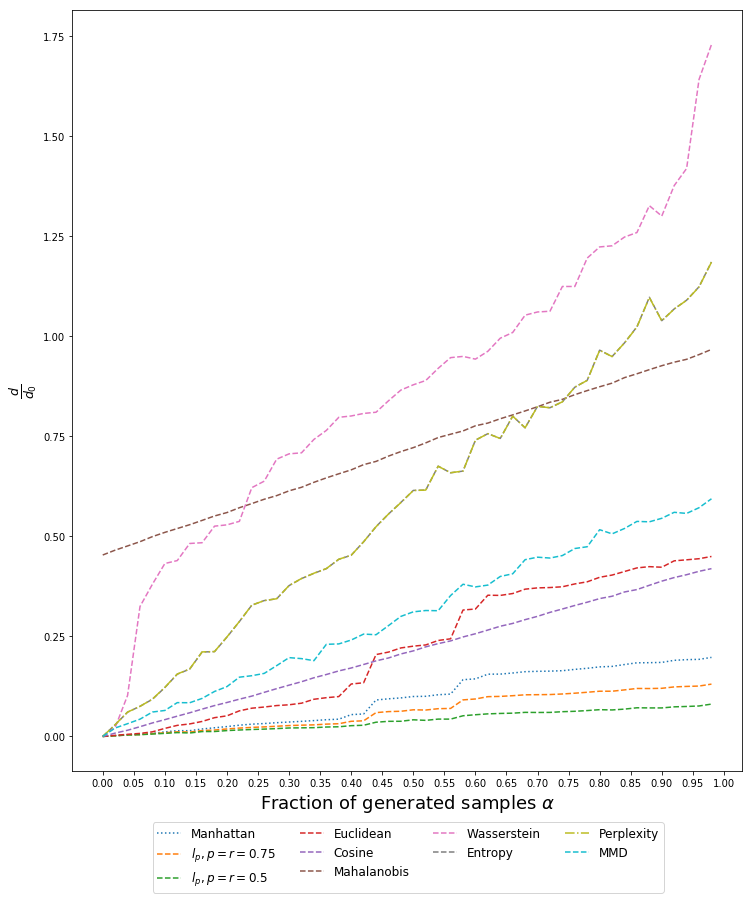

In [13]:
fig = plt.figure(figsize=(12,14))
plt.plot(alphagrid, normalized_man, ':', label='Manhattan')
plt.plot(alphagrid, normalized_lp, '--', label=r'$l_p, p=r=0.75$')
plt.plot(alphagrid, normalized_lp_2, '--', label=r'$l_p, p=r=0.5$')
plt.plot(alphagrid, normalized_euc, '--', label='Euclidean')
plt.plot(alphagrid, normalized_cosine, '--', label='Cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, normalized_mah, '--', label='Mahalanobis')
plt.plot(alphagrid, normalized_wass, '--', label='Wasserstein')
#plt.plot(alphagrid, normalized_fid, '--', label='FID')
plt.plot(alphagrid, normalized_ent, '--', label='Entropy')
plt.plot(alphagrid, normalized_perp, '-.', label='Perplexity')
plt.plot(alphagrid, normalized_mmd, '--', label='MMD')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.ylabel(r'$\frac{d}{d_0}$', fontsize=18)
plt.xlabel(r'Fraction of generated samples $\alpha$', fontsize=18)

plt.legend(fontsize=12, ncol=4, loc=(0.12,-0.16))
plt.savefig('figures/discriminative/eps/untransformed_100_1000.eps')
plt.savefig('figures/discriminative/png/untransformed_100_1000.png')
plt.show()

## Alt Approach length 1000, 100 samples


In [19]:
real_samples = load_n_samples(real=True, sample_length=1000,num_samples=100, random_state=42)
fake_samples = load_n_samples(real=False, sample_length=1000,num_samples=100, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=1000,num_samples=100, random_state=69)
fake_samples_2 = load_n_samples(real=False, sample_length=1000,num_samples=100, random_state=69)

Sr1 = np.array(real_samples).astype(np.float64)
Sr2 = np.array(fake_samples).astype(np.float64)
S_2 = np.array(real_samples_2).astype(np.float64)
G_2 = np.array(fake_samples_2).astype(np.float64)

num_cols = Sr1.shape[1]
sample_length = 1000
num_samples = 100
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))
S_2 = np.reshape(S_2, (num_samples, sample_length, num_cols))
G_2 = np.reshape(G_2, (num_samples, sample_length, num_cols))


print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
#d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
#print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1, S_2, G1=Sr2, G2=G_2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)

True
True
lp, p=0.75, r=0.75:  237816296000.65015
lp, p=0.5, r=0.5:  22190107227132.6
euclidean:  965944055.709161
cosine:  0.47092668949326977
Mahalanobis:  3.6169318591141346
wasserstein:  25099064.541221995
FID:  257672508.87828022
Entropy:  0.3874186409633655
Perplexity:  6.714047050107687
MMD:  0.43427963422911486


In [20]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.array(alt_create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 100, random_state=42)).astype(np.float64)
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.array(alt_create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 100, random_state=69)).astype(np.float64)
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    #d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=S_2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd')
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    #chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [21]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores
normalized_mah = mah_scores/d0_mah
normalized_wass = wass_scores/d0_wass
normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd

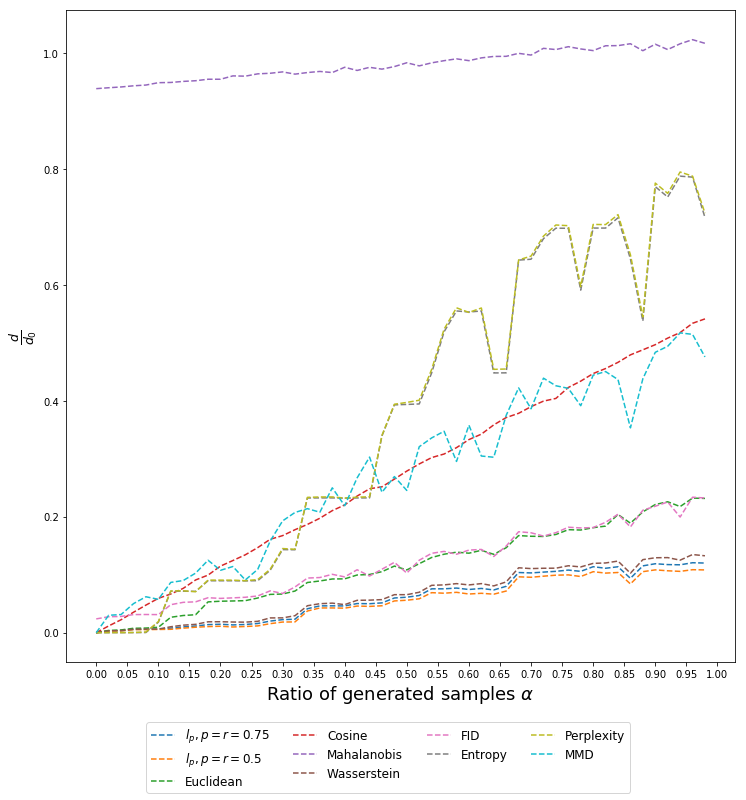

In [22]:
fig = plt.figure(figsize=(12,14))
plt.plot(alphagrid, normalized_man, ':', label='Manhattan')
plt.plot(alphagrid, normalized_lp, '--', label=r'$l_p, p=r=0.75$')
plt.plot(alphagrid, normalized_lp_2, '--', label=r'$l_p, p=r=0.5$')
plt.plot(alphagrid, normalized_euc, '--', label='Euclidean')
plt.plot(alphagrid, normalized_cosine, '--', label='Cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, normalized_mah, '--', label='Mahalanobis')
plt.plot(alphagrid, normalized_wass, '--', label='Wasserstein')
#plt.plot(alphagrid, normalized_fid, '--', label='FID')
plt.plot(alphagrid, normalized_ent, '--', label='Entropy')
plt.plot(alphagrid, normalized_perp, '-.', label='Perplexity')
plt.plot(alphagrid, normalized_mmd, '--', label='MMD')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.ylabel(r'$\frac{d}{d_0}$', fontsize=18)
plt.xlabel(r'Fraction of generated samples $\alpha$', fontsize=18)

plt.legend(fontsize=12, ncol=4, loc=(0.12,-0.16))
plt.savefig('figures/discriminative/eps/untransformed_1000_100.eps')
plt.savefig('figures/discriminative/png/untransformed_1000_100.png')
plt.show()

## Alt Approach 1000 1000

In [16]:
real_samples = load_n_samples(real=True, sample_length=1000,num_samples=1000, random_state=42)
fake_samples = load_n_samples(real=False, sample_length=1000,num_samples=1000, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=1000,num_samples=1000, random_state=69)
fake_samples_2 = load_n_samples(real=False, sample_length=1000,num_samples=1000, random_state=69)

Sr1 = np.array(real_samples).astype(np.float64)
Sr2 = np.array(fake_samples).astype(np.float64)
S_2 = np.array(real_samples_2).astype(np.float64)
G_2 = np.array(fake_samples_2).astype(np.float64)

num_cols = Sr1.shape[1]
sample_length = 1000
num_samples = 1000
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))
S_2 = np.reshape(S_2, (num_samples, sample_length, num_cols))
G_2 = np.reshape(G_2, (num_samples, sample_length, num_cols))


print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_man = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1., r=1.)
print("lp, p=1, r=1: ", d0_man)
d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
#d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
#print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
#d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
#print("FID: ", d0_fid)
d0_ent_std = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=True)
print("Standardized Entropy: ", d0_ent_std)
d0_perp_std = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=True)
print("Standardized Perplexity: ", d0_perp_std)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1, S_2, G1=Sr2, G2=G_2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)


True
True
lp, p=1, r=1:  249156217270.8098
lp, p=0.75, r=0.75:  249156217270.8098
lp, p=0.5, r=0.5:  22727261643873.094
euclidean:  1168798506.0893285
cosine:  0.45655746289382737
Mahalanobis:  2.5147102899487317
chi:  2.3254837199375592e+203
wasserstein:  0.0899850489045459
Standardized Entropy:  0.07006801933227837
Standardized Perplexity:  0.07016798766451003
Entropy:  0.4840127304303682
Perplexity:  8.455605859657535
MMD:  0.4737573998196299


In [17]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
man_scores = np.array([])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
#fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
ent_scores_std = np.array([])
perp_scores_std = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.array(alt_create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 1000, random_state=42)).astype(np.float64)
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.array(alt_create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 1000, random_state=69)).astype(np.float64)
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    d_man = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1., r=1.)
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    #d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    #d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent_std = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=True)
    d_perp_std = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=True)
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=S_2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd')
    lp_scores = np.append(lp_scores, d_lp)
    man_scores = np.append(man_scores, d_man)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    #chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    #fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    ent_scores_std = np.append(ent_scores_std, d_ent_std)
    perp_scores_std = np.append(perp_scores_std, d_perp_std)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [18]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores
normalized_mah = mah_scores/d0_mah
#normalized_chi = chi_scores/d0_chi
normalized_wass = wass_scores/d0_wass
#normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_ent_std = ent_scores_std/d0_ent_std
normalized_perp_std = perp_scores_std/d0_perp_std
normalized_mmd = mmd_scores/d0_mmd
normalized_man = man_scores/d0_man

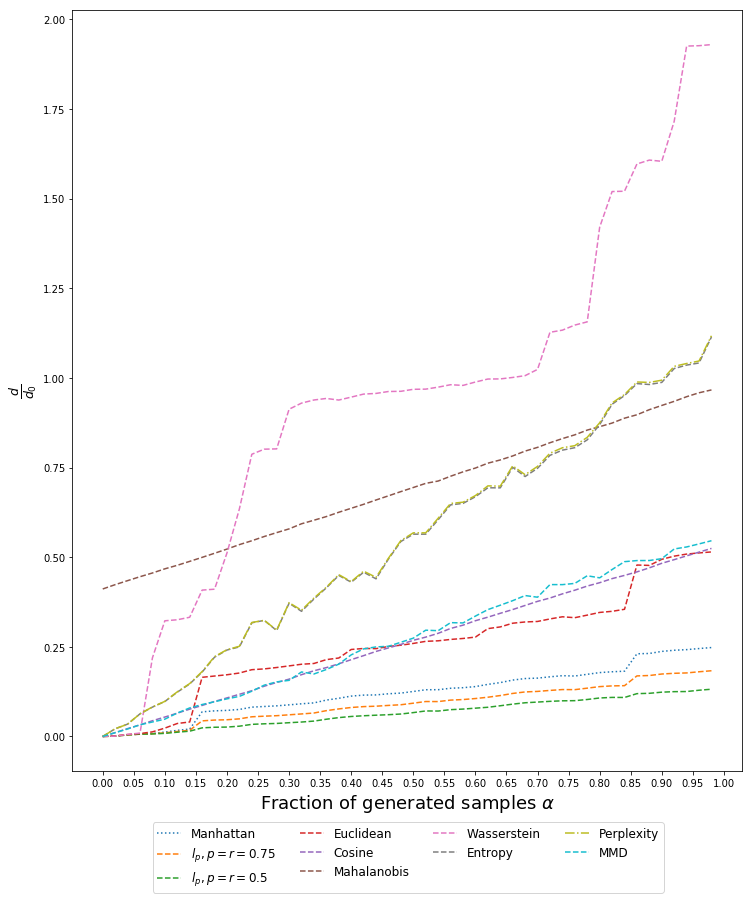

In [22]:
fig = plt.figure(figsize=(12,14))
plt.plot(alphagrid, normalized_man, ':', label='Manhattan')
plt.plot(alphagrid, normalized_lp, '--', label=r'$l_p, p=r=0.75$')
plt.plot(alphagrid, normalized_lp_2, '--', label=r'$l_p, p=r=0.5$')
plt.plot(alphagrid, normalized_euc, '--', label='Euclidean')
plt.plot(alphagrid, normalized_cosine, '--', label='Cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, normalized_mah, '--', label='Mahalanobis')
plt.plot(alphagrid, normalized_wass, '--', label='Wasserstein')
#plt.plot(alphagrid, normalized_fid, '--', label='FID')
plt.plot(alphagrid, normalized_ent, '--', label='Entropy')
plt.plot(alphagrid, normalized_perp, '-.', label='Perplexity')
#plt.plot(alphagrid, normalized_ent_std, '--', label='Standardized Entropy')
#plt.plot(alphagrid, normalized_perp_std, '-.', label='Standardized Perplexity')
plt.plot(alphagrid, normalized_mmd, '--', label='MMD')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.ylabel(r'$\frac{d}{d_0}$', fontsize=18)
plt.xlabel(r'Fraction of generated samples $\alpha$', fontsize=18)

plt.legend(fontsize=12, ncol=4, loc=(0.12,-0.16))
plt.savefig('figures/discriminative/eps/untransformed_1000_1000.eps')
plt.savefig('figures/discriminative/png/untransformed_1000_1000.png')
plt.show()

## PCA Approach

In [42]:

real_samples = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=42)
fake_samples = load_n_samples(real=False, sample_length=100,num_samples=100, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=100,num_samples=100, random_state=69)
fake_samples_2 = load_n_samples(real=False, sample_length=100,num_samples=100, random_state=69)

Sr1 = np.array(real_samples).astype(np.float64)
Sr2 = np.array(fake_samples).astype(np.float64)
S_2 = np.array(real_samples_2).astype(np.float64)
G_2 = np.array(fake_samples_2).astype(np.float64)

num_cols = Sr1.shape[1]
sample_length = 100
num_samples = 100
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))
S_2 = np.reshape(S_2, (num_samples, sample_length, num_cols))
G_2 = np.reshape(G_2, (num_samples, sample_length, num_cols))

# Do PCA on all the samples
Sr1_pca = np.zeros((num_samples, num_cols, num_cols))
Sr2_pca = np.zeros((num_samples, num_cols, num_cols))
S_2_pca = np.zeros((num_samples, num_cols, num_cols))
G_2_pca = np.zeros((num_samples, num_cols, num_cols))

pca = PCA()
for x in range(num_samples):
    pca.fit(Sr1[x])
    Sr1_pca[x] = pca.components_
    
    pca.fit(Sr2[x])
    Sr2_pca[x] = pca.components_
    
    pca.fit(S_2[x])
    S_2_pca[x] = pca.components_
    
    pca.fit(G_2[x])
    G_2_pca[x] = pca.components_
sample_length = Sr2_pca.shape[1]

print(Sr1_pca.shape)

d0_lp = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2_pca,Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
d0_chi = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
d0_fid = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='fid')
print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1_pca, S_2_pca, G1=Sr2_pca, G2=G_2_pca, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)


(100, 10, 10)
lp, p=0.75, r=0.75:  3.122174320061753
lp, p=0.5, r=0.5:  8.334421373162256
euclidean:  1.3401914823974903
cosine:  1.0049832763446522
Mahalanobis:  3.9230090491866054
chi:  2.9596730860192116e+21
wasserstein:  0.12202232418137912
FID:  12.149846469685858
Entropy:  0.09036559147526364
Perplexity:  0.257067559970345
MMD:  0.13767993646947274


In [43]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
sample_length_orig = 100
for alpha in alphagrid:
    Sg_t = np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 100, random_state=42)).astype(np.float64)
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length_orig, num_cols))
    
    Sg_t2 = np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 100, random_state=69)).astype(np.float64)
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length_orig, num_cols))
    Sg_t_pca = np.zeros((num_samples, num_cols, num_cols))
    Sg_t2_pca = np.zeros((num_samples, num_cols, num_cols))
    
    for x in range(num_samples):
        pca.fit(Sg_t[x])
        Sg_t_pca[x] = pca.components_
        pca.fit(Sg_t2[x])
        Sg_t2_pca[x] = pca.components_
    sample_length = Sg_t_pca.shape[1]    
    d_lp = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    #d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    d_fid = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1_pca, S2=S_2_pca,G1=Sg_t_pca, G2=Sg_t2_pca, sample_length=sample_length, num_samples=num_samples, metric='mmd')
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    #chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [44]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores
normalized_mah = mah_scores/d0_mah
normalized_wass = wass_scores/d0_wass
normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd

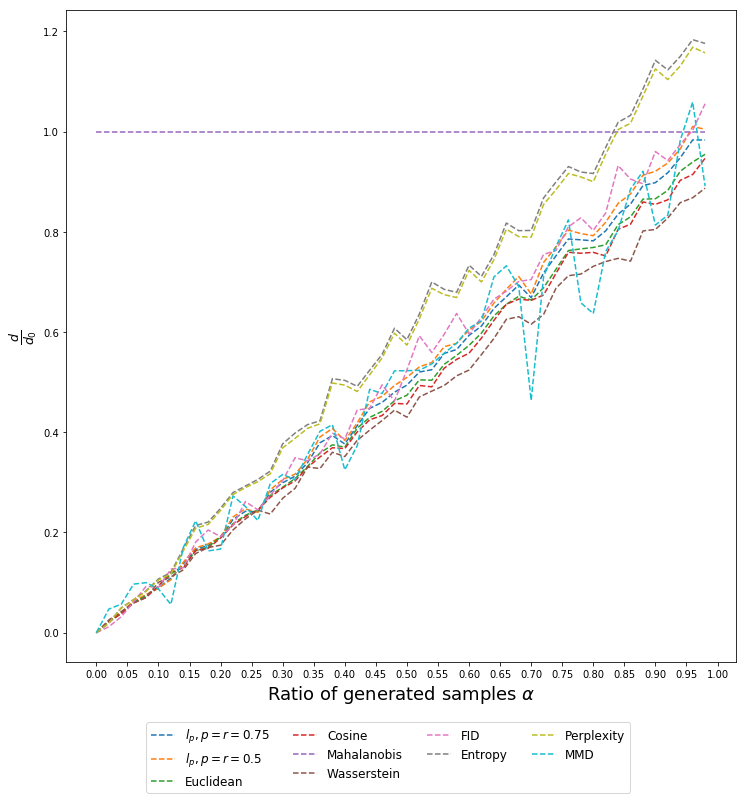

In [45]:
fig = plt.figure(figsize=(12,12))
plt.plot(alphagrid, normalized_lp, '--', label=r'$l_p, p=r=0.75$')
plt.plot(alphagrid, normalized_lp_2, '--', label=r'$l_p, p=r=0.5$')
plt.plot(alphagrid, normalized_euc, '--', label='Euclidean')
plt.plot(alphagrid, normalized_cosine, '--', label='Cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, normalized_mah, '--', label='Mahalanobis')
plt.plot(alphagrid, normalized_wass, '--', label='Wasserstein')
plt.plot(alphagrid, normalized_fid, '--', label='FID')
plt.plot(alphagrid, normalized_ent, '--', label='Entropy')
plt.plot(alphagrid, normalized_perp, '--', label='Perplexity')
plt.plot(alphagrid, normalized_mmd, '--', label='MMD')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.ylabel(r'$\frac{d}{d_0}$', fontsize=18)
plt.xlabel(r'Fraction of generated samples $\alpha$', fontsize=18)

plt.legend(fontsize=12, ncol=4, loc=(0.12,-0.2))
#plt.savefig('figures/discriminative/eps/pca_100_100.eps')
#plt.savefig('figures/discriminative/png/pca_100_100.png')
plt.show()

## PCA 100-1000

In [26]:
real_samples = load_n_samples(real=True, sample_length=100,num_samples=1000, random_state=42)
fake_samples = load_n_samples(real=False, sample_length=100,num_samples=1000, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=100,num_samples=1000, random_state=69)
fake_samples_2 = load_n_samples(real=False, sample_length=100,num_samples=1000, random_state=69)

Sr1 = np.array(real_samples).astype(np.float64)
Sr2 = np.array(fake_samples).astype(np.float64)
S_2 = np.array(real_samples_2).astype(np.float64)
G_2 = np.array(fake_samples_2).astype(np.float64)

num_cols = Sr1.shape[1]
sample_length = 100
num_samples = 1000
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))
S_2 = np.reshape(S_2, (num_samples, sample_length, num_cols))
G_2 = np.reshape(G_2, (num_samples, sample_length, num_cols))

# Do PCA on all the samples
Sr1_pca = np.zeros((num_samples, num_cols, num_cols))
Sr2_pca = np.zeros((num_samples, num_cols, num_cols))
S_2_pca = np.zeros((num_samples, num_cols, num_cols))
G_2_pca = np.zeros((num_samples, num_cols, num_cols))

pca = PCA()
for x in range(num_samples):
    pca.fit(Sr1[x])
    Sr1_pca[x] = pca.components_
    
    pca.fit(Sr2[x])
    Sr2_pca[x] = pca.components_
    
    pca.fit(S_2[x])
    S_2_pca[x] = pca.components_
    
    pca.fit(G_2[x])
    G_2_pca[x] = pca.components_
sample_length = Sr2_pca.shape[1]

print(Sr1_pca.shape)

d0_man = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1., r=1.)
print("Manhattan: ", d0_man)
d0_lp = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2_pca,Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
#d0_chi = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
#print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
d0_fid = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='fid')
print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1_pca, S_2_pca, G1=Sr2_pca, G2=G_2_pca, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)

(1000, 10, 10)
Manhattan:  2.0698808162626956
lp, p=0.75, r=0.75:  3.07633647491402
lp, p=0.5, r=0.5:  8.235441326487944
euclidean:  1.319496572554733
cosine:  0.9900019172013099
Mahalanobis:  4.464130274243659
wasserstein:  0.7854775341150817
FID:  12.428312683401533
Entropy:  0.09697369995071219
Perplexity:  0.273546892757125
MMD:  0.131080716877751


In [27]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
man_scores = np.array([])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
sample_length_orig = 100
for alpha in alphagrid:
    Sg_t = np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 1000, random_state=42)).astype(np.float64)
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length_orig, num_cols))
    
    Sg_t2 = np.array(alt_create_sample_mix(ratio=alpha, sample_length=100, num_samples = 1000, random_state=69)).astype(np.float64)
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length_orig, num_cols))
    Sg_t_pca = np.zeros((num_samples, num_cols, num_cols))
    Sg_t2_pca = np.zeros((num_samples, num_cols, num_cols))
    
    for x in range(num_samples):
        pca.fit(Sg_t[x])
        Sg_t_pca[x] = pca.components_
        pca.fit(Sg_t2[x])
        Sg_t2_pca[x] = pca.components_
    sample_length = Sg_t_pca.shape[1]   
    d_man = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1., r=1.)
    d_lp = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    #d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    d_fid = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1_pca, S2=S_2_pca,G1=Sg_t_pca, G2=Sg_t2_pca, sample_length=sample_length, num_samples=num_samples, metric='mmd')
    man_scores = np.append(man_scores, d_man)
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    #chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [28]:
normalized_man = man_scores/d0_man
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores
normalized_mah = mah_scores/d0_mah
normalized_wass = wass_scores/d0_wass
#normalized_chi = chi_scores/d0_chi
normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd
#print(normalized_chi)

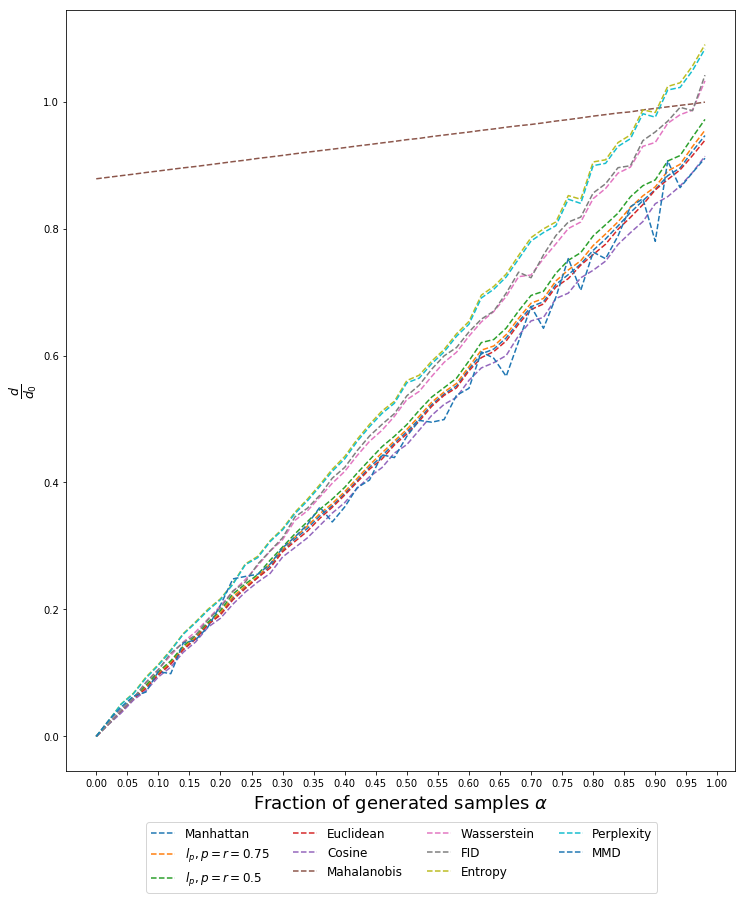

In [32]:
fig = plt.figure(figsize=(12,14))
plt.plot(alphagrid, normalized_man, '--', label='Manhattan')
plt.plot(alphagrid, normalized_lp, '--', label=r'$l_p, p=r=0.75$')
plt.plot(alphagrid, normalized_lp_2, '--', label=r'$l_p, p=r=0.5$')
plt.plot(alphagrid, normalized_euc, '--', label='Euclidean')
plt.plot(alphagrid, normalized_cosine, '--', label='Cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, normalized_mah, '--', label='Mahalanobis')
plt.plot(alphagrid, normalized_wass, '--', label='Wasserstein')
plt.plot(alphagrid, normalized_fid, '--', label='FID')
plt.plot(alphagrid, normalized_ent, '--', label='Entropy')
plt.plot(alphagrid, normalized_perp, '--', label='Perplexity')
plt.plot(alphagrid, normalized_mmd, '--', label='MMD')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.ylabel(r'$\frac{d}{d_0}$', fontsize=18)
plt.xlabel(r'Fraction of generated samples $\alpha$', fontsize=18)

plt.legend(fontsize=12, ncol=4, loc=(0.12,-0.16))
plt.savefig('figures/discriminative/eps/pca_100_1000.eps')
plt.savefig('figures/discriminative/png/pca_100_1000.png')
plt.show()

## PCA Transformed Data 1000-100

## PCA 1000-1000

In [33]:
real_samples = load_n_samples(real=True, sample_length=1000,num_samples=1000, random_state=42)
fake_samples = load_n_samples(real=False, sample_length=1000,num_samples=1000, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=1000,num_samples=1000, random_state=69)
fake_samples_2 = load_n_samples(real=False, sample_length=1000,num_samples=1000, random_state=69)

Sr1 = np.array(real_samples).astype(np.float64)
Sr2 = np.array(fake_samples).astype(np.float64)
S_2 = np.array(real_samples_2).astype(np.float64)
G_2 = np.array(fake_samples_2).astype(np.float64)

num_cols = Sr1.shape[1]
sample_length = 1000
num_samples = 1000
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))
S_2 = np.reshape(S_2, (num_samples, sample_length, num_cols))
G_2 = np.reshape(G_2, (num_samples, sample_length, num_cols))

# Do PCA on all the samples
Sr1_pca = np.zeros((num_samples, num_cols, num_cols))
Sr2_pca = np.zeros((num_samples, num_cols, num_cols))
S_2_pca = np.zeros((num_samples, num_cols, num_cols))
G_2_pca = np.zeros((num_samples, num_cols, num_cols))

pca = PCA()
for x in range(num_samples):
    pca.fit(Sr1[x])
    Sr1_pca[x] = pca.components_
    
    pca.fit(Sr2[x])
    Sr2_pca[x] = pca.components_
    
    pca.fit(S_2[x])
    S_2_pca[x] = pca.components_
    
    pca.fit(G_2[x])
    G_2_pca[x] = pca.components_
sample_length = Sr2_pca.shape[1]

print(Sr1_pca.shape)

d0_man = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1., r=1.)
print("Manhattan: ", d0_man)
d0_lp = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2_pca,Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
#d0_chi = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
#print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
d0_fid = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='fid')
print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1_pca, S_2_pca, G1=Sr2_pca, G2=G_2_pca, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)

(1000, 10, 10)
Manhattan:  2.0104436268610284
lp, p=0.75, r=0.75:  2.9088877217656317
lp, p=0.5, r=0.5:  7.37529386674029
euclidean:  1.3175428664749602
cosine:  0.993181470370113
Mahalanobis:  4.4617582301554854
wasserstein:  0.72472342717788
FID:  10.813358434772445
Entropy:  0.07813666577677054
Perplexity:  0.2252814532162687
MMD:  0.16040871689639027


In [34]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
man_scores = np.array([])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
#chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
sample_length_orig = 1000
for alpha in alphagrid:
    Sg_t = np.array(alt_create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 1000, random_state=42)).astype(np.float64)
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length_orig, num_cols))
    
    Sg_t2 = np.array(alt_create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 1000, random_state=69)).astype(np.float64)
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length_orig, num_cols))
    Sg_t_pca = np.zeros((num_samples, num_cols, num_cols))
    Sg_t2_pca = np.zeros((num_samples, num_cols, num_cols))
    
    for x in range(num_samples):
        pca.fit(Sg_t[x])
        Sg_t_pca[x] = pca.components_
        pca.fit(Sg_t2[x])
        Sg_t2_pca[x] = pca.components_
    sample_length = Sg_t_pca.shape[1]   
    d_man = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=1., r=1.)
    d_lp = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    #d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    d_fid = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t_pca, Sr1_pca, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1_pca, S2=S_2_pca,G1=Sg_t_pca, G2=Sg_t2_pca, sample_length=sample_length, num_samples=num_samples, metric='mmd')
    man_scores = np.append(man_scores, d_man)
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    #chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [35]:
normalized_man = man_scores/d0_man
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores
normalized_mah = mah_scores/d0_mah
normalized_wass = wass_scores/d0_wass
#normalized_chi = chi_scores/d0_chi
normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd
#print(normalized_chi)

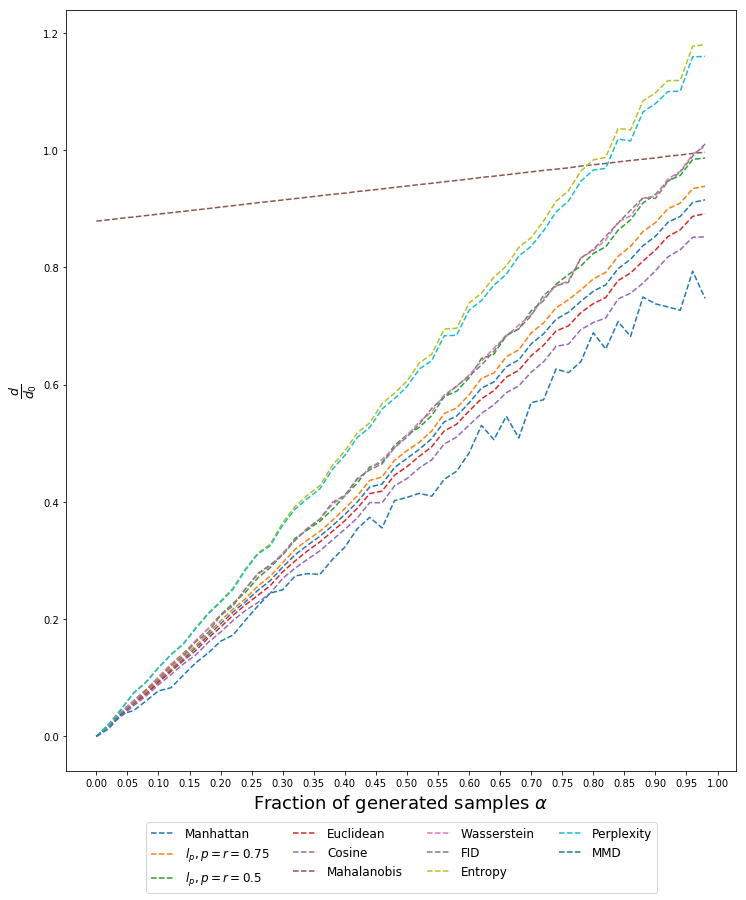

In [36]:
fig = plt.figure(figsize=(12,14))
plt.plot(alphagrid, normalized_man, '--', label='Manhattan')
plt.plot(alphagrid, normalized_lp, '--', label=r'$l_p, p=r=0.75$')
plt.plot(alphagrid, normalized_lp_2, '--', label=r'$l_p, p=r=0.5$')
plt.plot(alphagrid, normalized_euc, '--', label='Euclidean')
plt.plot(alphagrid, normalized_cosine, '--', label='Cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, normalized_mah, '--', label='Mahalanobis')
plt.plot(alphagrid, normalized_wass, '--', label='Wasserstein')
plt.plot(alphagrid, normalized_fid, '--', label='FID')
plt.plot(alphagrid, normalized_ent, '--', label='Entropy')
plt.plot(alphagrid, normalized_perp, '--', label='Perplexity')
plt.plot(alphagrid, normalized_mmd, '--', label='MMD')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.ylabel(r'$\frac{d}{d_0}$', fontsize=18)
plt.xlabel(r'Fraction of generated samples $\alpha$', fontsize=18)

plt.legend(fontsize=12, ncol=4, loc=(0.12,-0.16))
plt.savefig('figures/discriminative/eps/pca_1000_1000.eps')
plt.savefig('figures/discriminative/png/pca_1000_1000.png')
plt.show()

## Original Approach

In [86]:
real_samples = load_n_samples(real=True, sample_length=1000,num_samples=100, random_state=42)
fake_samples = load_n_samples(real=False, sample_length=1000,num_samples=100, random_state=42)

Sr1 = np.array(real_samples).astype(np.float64)
Sr2 = np.array(fake_samples).astype(np.float64)

num_cols = Sr1.shape[1]
sample_length = 1000
num_samples = 100
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))

print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1, Sr2, G1=Sr1, G2=Sr2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)

True
True
lp, p=0.75, r=0.75:  237816296000.65015
lp, p=0.5, r=0.5:  22190107227132.6
euclidean:  965944055.709161
cosine:  0.47092668949326977
Mahalanobis:  3.6169318591141346
chi:  1.9107283942027164e+26
wasserstein:  25099064.541221995
FID:  8.239496665758557e+17
Entropy:  0.3874186409633655
Perplexity:  6.714047050107687
MMD:  1.0711994162675205


In [87]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.array(alt_create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 100, random_state=42)).astype(np.float64)
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    #Sg_t2 = np.array(create_sample_mix(ratio=alpha, sample_length=100, num_samples = 100, random_state=42)).astype(np.float64)
    #Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(Sr1, Sg_t, G1=Sr1, G2=Sg_t, sample_length=sample_length, num_samples=num_samples, metric='mmd')
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [88]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores/d0_cosine
normalized_mah = mah_scores/d0_mah
normalized_chi = chi_scores/d0_chi
normalized_wass = wass_scores/d0_wass
normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp

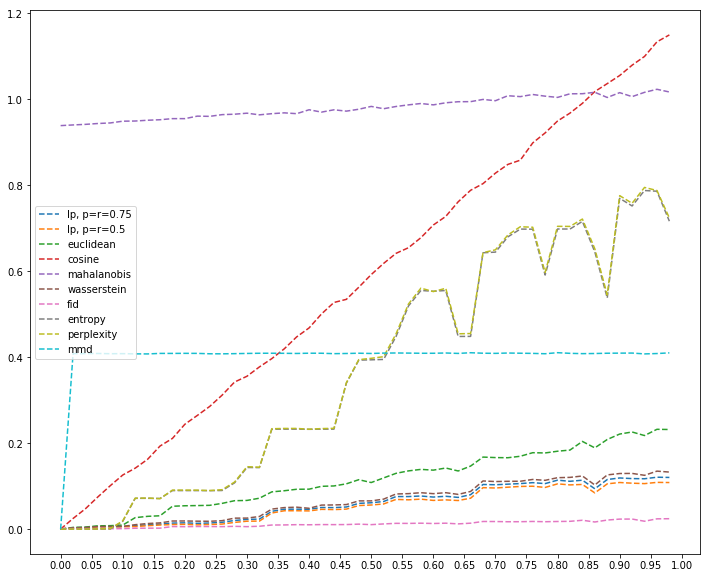

In [89]:
fig = plt.figure(figsize=(12,10))
plt.plot(alphagrid, np.abs(normalized_lp), '--', label='lp, p=r=0.75')
plt.plot(alphagrid, np.abs(normalized_lp_2), '--', label='lp, p=r=0.5')
plt.plot(alphagrid, np.abs(normalized_euc), '--', label='euclidean')
plt.plot(alphagrid, np.abs(normalized_cosine), '--', label='cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, np.abs(normalized_mah), '--', label='mahalanobis')
plt.plot(alphagrid, np.abs(normalized_wass), '--', label='wasserstein')
plt.plot(alphagrid, np.abs(normalized_fid), '--', label='fid')
plt.plot(alphagrid, np.abs(normalized_ent), '--', label='entropy')
plt.plot(alphagrid, np.abs(normalized_perp), '--', label='perplexity')
plt.plot(alphagrid, np.abs(normalized_mmd), '--', label='mmd')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.legend()
plt.show()

## Test Discriminative Behavior

### Sample length 100 - 100 samples

In [51]:
Sr1 = np.array(real_samples).astype(np.float64)
Sr2 = np.array(real_samples_2).astype(np.float64)

num_cols = Sr1.shape[1]
sample_length = 100
num_samples = 100
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))

print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1, Sr2, G1=Sr1, G2=Sr2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)


True
True
lp, p=0.75, r=0.75:  11394043145.248344
lp, p=0.5, r=0.5:  152376339083.3594
euclidean:  728948671.3831618
cosine:  0.39803420159241987
Mahalanobis:  3.222976757020259
chi:  8.544948718757911e+33
wasserstein:  33853917.671009995
FID:  1.6701463962045778e+19
Entropy:  0.6280859475240914
Perplexity:  3.20210377934053
MMD:  0.9381776045436819


In [52]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.array(create_sample_mix(ratio=alpha, sample_length=100, num_samples = 100, random_state=333)).astype(np.float64)
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.array(create_sample_mix(ratio=alpha, sample_length=100, num_samples = 100, random_state=42)).astype(np.float64)
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=Sr2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd')
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [53]:

normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores/d0_cosine
normalized_mah = mah_scores/d0_mah
normalized_chi = chi_scores/d0_chi
normalized_wass = wass_scores/d0_wass
normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd
"""
normalized_lp = (lp_scores-d0_lp)/d0_lp
normalized_lp_2 = (lp_2_scores-d0_lp_2)/d0_lp_2
normalized_euc = (euc_scores-d0_euc)/d0_euc
normalized_cosine = (cosine_scores-d0_cosine)/d0_cosine
normalized_mah = (mah_scores-d0_mah)/d0_mah
normalized_chi = (chi_scores-d0_chi)/d0_chi
normalized_wass = (wass_scores-d0_wass)/d0_wass
normalized_fid = (fid_scores-d0_fid)/d0_fid
normalized_ent = (ent_scores-d0_ent)/d0_ent
normalized_perp = (perp_scores-d0_perp)/d0_perp
"""

'\nnormalized_lp = (lp_scores-d0_lp)/d0_lp\nnormalized_lp_2 = (lp_2_scores-d0_lp_2)/d0_lp_2\nnormalized_euc = (euc_scores-d0_euc)/d0_euc\nnormalized_cosine = (cosine_scores-d0_cosine)/d0_cosine\nnormalized_mah = (mah_scores-d0_mah)/d0_mah\nnormalized_chi = (chi_scores-d0_chi)/d0_chi\nnormalized_wass = (wass_scores-d0_wass)/d0_wass\nnormalized_fid = (fid_scores-d0_fid)/d0_fid\nnormalized_ent = (ent_scores-d0_ent)/d0_ent\nnormalized_perp = (perp_scores-d0_perp)/d0_perp\n'

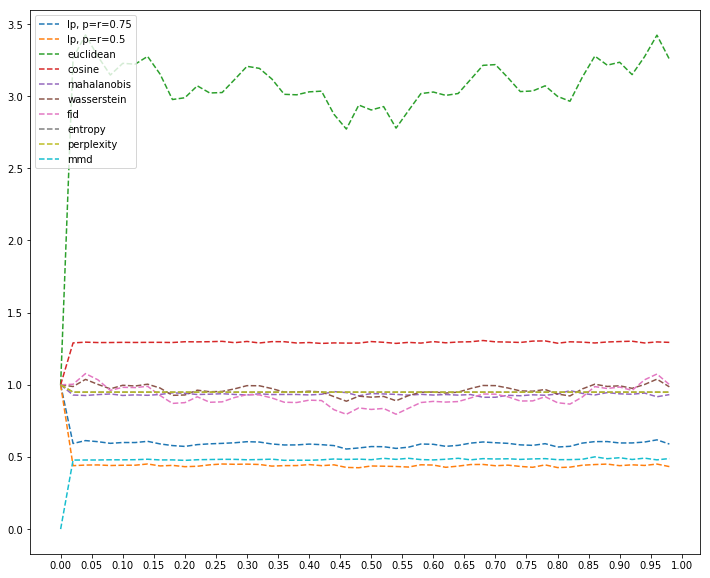

In [54]:

fig = plt.figure(figsize=(12,10))
plt.plot(alphagrid, np.abs(normalized_lp), '--', label='lp, p=r=0.75')
plt.plot(alphagrid, np.abs(normalized_lp_2), '--', label='lp, p=r=0.5')
plt.plot(alphagrid, np.abs(normalized_euc), '--', label='euclidean')
plt.plot(alphagrid, np.abs(normalized_cosine), '--', label='cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, np.abs(normalized_mah), '--', label='mahalanobis')
plt.plot(alphagrid, np.abs(normalized_wass), '--', label='wasserstein')
plt.plot(alphagrid, np.abs(normalized_fid), '--', label='fid')
plt.plot(alphagrid, np.abs(normalized_ent), '--', label='entropy')
plt.plot(alphagrid, np.abs(normalized_perp), '--', label='perplexity')
plt.plot(alphagrid, np.abs(normalized_mmd), '--', label='mmd')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.legend()
plt.show()


## Test Discriminative Behavior on sample length 100 - 1000 Samples

In [55]:
real_samples = load_n_samples(real=True, sample_length=100,num_samples=1000, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=100,num_samples=1000, random_state=333)

In [56]:
Sr1 = np.array(real_samples).astype(np.float64)
Sr2 = np.array(real_samples_2).astype(np.float64)

num_cols = Sr1.shape[1]
sample_length = 100
num_samples = 1000
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))

print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1, Sr2, G1=Sr1, G2=Sr2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)


True
True
lp, p=0.75, r=0.75:  6333181178.779034
lp, p=0.5, r=0.5:  78322618268.49937
euclidean:  686487972.9880952
cosine:  0.4177172759414329
Mahalanobis:  3.276055420024808
chi:  4.855238914639014e+107
wasserstein:  21735881.175375998
FID:  2.0809407488532e+19
Entropy:  0.8118906218697627
Perplexity:  4.124659432902145
MMD:  0.9446657344096375


In [57]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.array(create_sample_mix(ratio=alpha, sample_length=100, num_samples = 1000, random_state=333)).astype(np.float64)
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.array(create_sample_mix(ratio=alpha, sample_length=100, num_samples = 1000, random_state=42)).astype(np.float64)
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=Sr2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [58]:

normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores/d0_cosine
normalized_mah = mah_scores/d0_mah
normalized_chi = chi_scores/d0_chi
normalized_wass = wass_scores/d0_wass
normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd


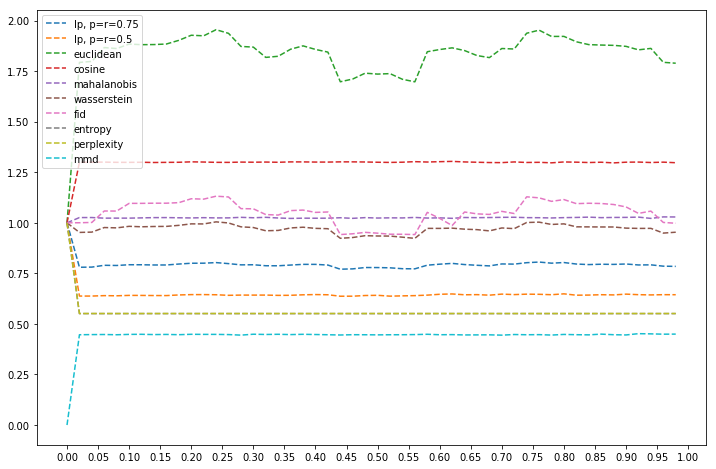

In [59]:
fig = plt.figure(figsize=(12,8))
plt.plot(alphagrid, np.abs(normalized_lp), '--', label='lp, p=r=0.75')
plt.plot(alphagrid, np.abs(normalized_lp_2), '--', label='lp, p=r=0.5')
plt.plot(alphagrid, np.abs(normalized_euc), '--', label='euclidean')
plt.plot(alphagrid, np.abs(normalized_cosine), '--', label='cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, np.abs(normalized_mah), '--', label='mahalanobis')
plt.plot(alphagrid, np.abs(normalized_wass), '--', label='wasserstein')
plt.plot(alphagrid, np.abs(normalized_fid), '--', label='fid')
plt.plot(alphagrid, np.abs(normalized_ent), '--', label='entropy')
plt.plot(alphagrid, np.abs(normalized_perp), '--', label='perplexity')
plt.plot(alphagrid, np.abs(mmd_scores), '--', label='mmd')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.legend()
plt.show()


## Test Discriminative Behavior on sample length 1000 with 100 samples

In [61]:
real_samples = load_n_samples(real=True, sample_length=1000,num_samples=100, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=1000,num_samples=100, random_state=333)

In [62]:
Sr1 = np.array(real_samples).astype(np.float64)
Sr2 = np.array(real_samples_2).astype(np.float64)
num_cols = Sr1.shape[1]
sample_length = 1000
num_samples = 100
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))

print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1, Sr2, G1=Sr1, G2=Sr2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)


True
True
lp, p=0.75, r=0.75:  21805450923.963444
lp, p=0.5, r=0.5:  1649319143621.0425
euclidean:  393128900.55656934
cosine:  0.5503063291897435
Mahalanobis:  3.6730711824940316
chi:  1.3697332260817574e+38
wasserstein:  3022247.972483001
FID:  1.706820162467573e+17
Entropy:  0.2713868311736108
Perplexity:  4.796846116924395
MMD:  0.9812354814759645


In [63]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.array(create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 100, random_state=333)).astype(np.float64)
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.array(create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 100, random_state=42)).astype(np.float64)
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=Sr2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [64]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores/d0_cosine
normalized_mah = mah_scores/d0_mah
normalized_chi = chi_scores/d0_chi
normalized_wass = wass_scores/d0_wass
normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd

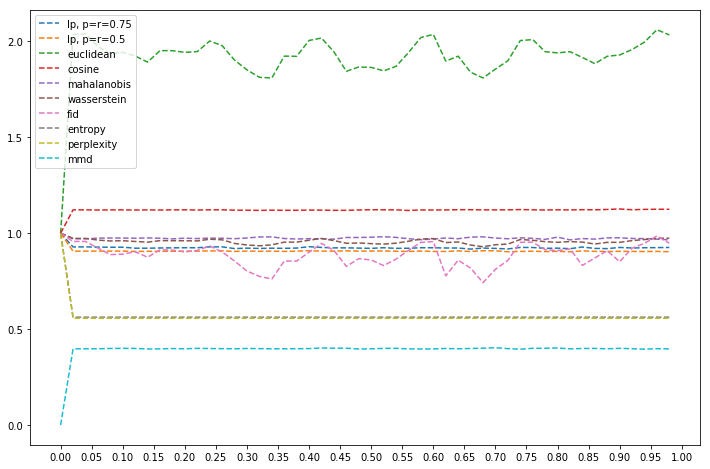

In [65]:
fig = plt.figure(figsize=(12,8))
plt.plot(alphagrid, np.abs(normalized_lp), '--', label='lp, p=r=0.75')
plt.plot(alphagrid, np.abs(normalized_lp_2), '--', label='lp, p=r=0.5')
plt.plot(alphagrid, np.abs(normalized_euc), '--', label='euclidean')
plt.plot(alphagrid, np.abs(normalized_cosine), '--', label='cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, np.abs(normalized_mah), '--', label='mahalanobis')
plt.plot(alphagrid, np.abs(normalized_wass), '--', label='wasserstein')
plt.plot(alphagrid, np.abs(normalized_fid), '--', label='fid')
plt.plot(alphagrid, np.abs(normalized_ent), '--', label='entropy')
plt.plot(alphagrid, np.abs(normalized_perp), '--', label='perplexity')
plt.plot(alphagrid, np.abs(mmd_scores), '--', label='mmd')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.legend()
plt.show()


## Test Discriminative Behavior on sample length 1000 with 500 samples

In [67]:
real_samples = load_n_samples(real=True, sample_length=1000,num_samples=500, random_state=42)
real_samples_2 = load_n_samples(real=True, sample_length=1000,num_samples=500, random_state=333)

In [68]:
Sr1 = np.array(real_samples).astype(np.float64)
Sr2 = np.array(real_samples_2).astype(np.float64)
num_cols = Sr1.shape[1]
sample_length = 1000
num_samples = 500
# Reshape into 3d array
Sr1 = np.reshape(Sr1, (num_samples, sample_length, num_cols))
Sr2 = np.reshape(Sr2, (num_samples, sample_length, num_cols))

print(np.isfinite(Sr1).all())
print(np.isfinite(Sr2).all())

d0_lp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
print("lp, p=0.75, r=0.75: ", d0_lp)
d0_lp_2 = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
print("lp, p=0.5, r=0.5: ", d0_lp_2)
d0_euc = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
print("euclidean: ", d0_euc)
d0_cosine = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
print("cosine: ", d0_cosine)
d0_mah = metrics.score_set(Sr2,Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
print("Mahalanobis: ", d0_mah)
d0_chi = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
print("chi: ", d0_chi)
d0_wass = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
print("wasserstein: ", d0_wass)
d0_fid = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
print("FID: ", d0_fid)
d0_ent = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
print("Entropy: ", d0_ent)
d0_perp = metrics.score_set(Sr2, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
print("Perplexity: ", d0_perp)
d0_mmd = metrics.score_set(Sr1, Sr2, G1=Sr1, G2=Sr2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
print("MMD: ", d0_mmd)


True
True
lp, p=0.75, r=0.75:  43732452266.08593
lp, p=0.5, r=0.5:  2648296965596.155
euclidean:  679686943.9868753
cosine:  0.5446048583712139
Mahalanobis:  3.617268337485585
chi:  7.60139763755253e+198
wasserstein:  6695870.504837003
FID:  3.8985180414068045e+18
Entropy:  0.4842784008629309
Perplexity:  8.476664786881608
MMD:  0.9884676407301525


In [69]:
alphagrid = np.around(np.arange(0.0,1.0,step=0.02), decimals=2)
#alphagrid = np.array([0.1])
lp_scores = np.array([])
lp_2_scores = np.array([])
euc_scores = np.array([])
cosine_scores = np.array([])
mah_scores = np.array([])
chi_scores = np.array([])
wass_scores = np.array([])
fid_scores = np.array([])
ent_scores = np.array([])
perp_scores = np.array([])
mmd_scores = np.array([])
for alpha in alphagrid:
    Sg_t = np.array(create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 500, random_state=333)).astype(np.float64)
    Sg_t = np.reshape(Sg_t, (num_samples, sample_length, num_cols))
    
    Sg_t2 = np.array(create_sample_mix(ratio=alpha, sample_length=1000, num_samples = 500, random_state=42)).astype(np.float64)
    Sg_t2 = np.reshape(Sg_t2, (num_samples, sample_length, num_cols))
    d_lp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.75, r=0.75)
    d_lp_2 = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=0.5, r=0.5)
    d_euc = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='lp', p=2, r=2)
    d_cosine = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='cosine')
    d_chi = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='chi_squared')
    d_wass = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='wasserstein')
    d_mah = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='mahalanobis')
    d_fid = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='fid')
    d_ent = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='entropy', standardized=False)
    d_perp = metrics.score_set(Sg_t, Sr1, sample_length=sample_length, num_samples=num_samples, metric='perplexity', standardized=False)
    d_mmd = metrics.score_set(S1=Sr1, S2=Sr2,G1=Sg_t, G2=Sg_t2, sample_length=sample_length, num_samples=num_samples, metric='mmd', standardized=False)
    lp_scores = np.append(lp_scores, d_lp)
    lp_2_scores = np.append(lp_2_scores, d_lp_2)
    euc_scores = np.append(euc_scores, d_euc)
    cosine_scores = np.append(cosine_scores, d_cosine)
    chi_scores = np.append(chi_scores, d_chi)
    mah_scores = np.append(mah_scores, d_mah)
    wass_scores = np.append(wass_scores, d_wass)
    fid_scores = np.append(fid_scores, d_fid)
    ent_scores = np.append(ent_scores, d_ent)
    perp_scores = np.append(perp_scores, d_perp)
    mmd_scores = np.append(mmd_scores, d_mmd)
    if int(100*alpha) % 10 == 0:
        print(alpha)
print("Finished")

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Finished


In [70]:
normalized_lp = lp_scores/d0_lp
normalized_lp_2 = lp_2_scores/d0_lp_2
normalized_euc = euc_scores/d0_euc
normalized_cosine = cosine_scores/d0_cosine
normalized_mah = mah_scores/d0_mah
normalized_chi = chi_scores/d0_chi
normalized_wass = wass_scores/d0_wass
normalized_fid = fid_scores/d0_fid
normalized_ent = ent_scores/d0_ent
normalized_perp = perp_scores/d0_perp
normalized_mmd = mmd_scores/d0_mmd

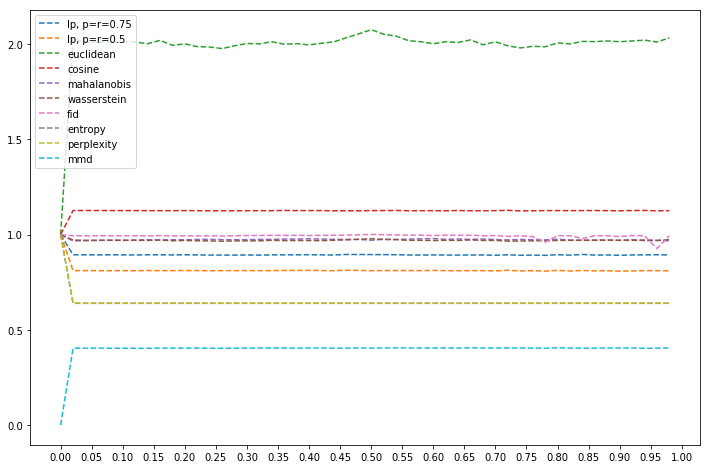

In [71]:
fig = plt.figure(figsize=(12,8))
plt.plot(alphagrid, np.abs(normalized_lp), '--', label='lp, p=r=0.75')
plt.plot(alphagrid, np.abs(normalized_lp_2), '--', label='lp, p=r=0.5')
plt.plot(alphagrid, np.abs(normalized_euc), '--', label='euclidean')
plt.plot(alphagrid, np.abs(normalized_cosine), '--', label='cosine')
#plt.plot(alphagrid, np.abs(normalized_chi), '--', label='chi')
plt.plot(alphagrid, np.abs(normalized_mah), '--', label='mahalanobis')
plt.plot(alphagrid, np.abs(normalized_wass), '--', label='wasserstein')
plt.plot(alphagrid, np.abs(normalized_fid), '--', label='fid')
plt.plot(alphagrid, np.abs(normalized_ent), '--', label='entropy')
plt.plot(alphagrid, np.abs(normalized_perp), '--', label='perplexity')
plt.plot(alphagrid, np.abs(mmd_scores), '--', label='mmd')
#plt.yticks(np.arange(0,1.01, step=0.1))
plt.xticks(np.arange(0,1.01, step=0.05))
plt.legend()
plt.show()
